Temurjon Ismailov
11/05/2024  
Web Scraping Project

In [174]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

### URL generator function
This function creates URLs for weather data based on a list of station IDs (strings), list of years (integers), and a target month (integer). It returns a dictionary where each key is a URL, and each value is a list containing the station ID and year associated with that URL.

In [ ]:
def get_urls(stations, years, month):   #function that generates a dict of urls
    url_base='https://www.wunderground.com/dashboard/pws/'     
    url_mod1 = '/table/'    
    url_mod2 = '/monthly'   
    station_url_dict = {}   #dict to store urls that gets returned. 
    for station_id in stations:
        for year in years:
            final_url = url_base + station_id
            url_mod3 = year + '-' + month + '-' + '4' + '/' + year + '-' + month + '-' + '4' #the four seems to be needed for the url. Just the way it generates. 
            final_url = final_url + url_mod1 + url_mod3 + url_mod2  #Builds a url with base, table view, monthly view, the years and month desired
            station_url_dict[final_url] = [station_id, year]    #store the url as a key and station id and year as the values. 
    return station_url_dict

### Url opener function
This function opens a given URL and returns a BeautifulSoup object (soup) of the page content. If the page loads successfully (status code 200), it converts the page text into a soup object. If there’s an issue, it prints an error message with the received status code.

In [ ]:
def get_page(station_link):     #function that opens each link and return soup of link
    url= station_link
    response = requests.get(url)
    status = response.status_code
    if status == 200:
        page = response.text
        soup = bs(page)
        return soup
    else:
        print(f"Oops! Received status code {status}")

### Scraper Function
This function scrapes weather data from a given BeautifulSoup page (soup). It locates the relevant table, iterates through rows to retrieve weather data and dates, and stores this information in a DataFrame. The function also retrieves the station's altitude separately, as it does not change within the page. The function returns the DataFrame containing weather data and the altitude as a separate value.

In [ ]:
def get_weather_data(page_soup):

    weather_data = [ ]
    weather_table = page_soup.find(class_='history-table desktop-table').tbody  #find table that stores all the weather data
    #print(weather_table)
    for row in weather_table.find_all('tr'):    #find every instance of 'tr' tag in table and loops through them
        #print (row)
        row_data = []      #holder for row data, gets inserted into weather data at each loop
        #print(weather_data) 
        for cell in row.find('strong'): #This loop is to get the dates, since they are stored differently. 
            row_data.append(cell)
        for cell in row.find_all('span', class_= 'wu-value wu-value-to' ): #This loops used to get weather data
            cell_data = (cell.text.strip())     #text.strip() removes all text
            row_data.append(cell_data)
            #print (row_data)
        weather_data.append(row_data)

    weather_df = pd.DataFrame(weather_data) #convert weather data to dataframe
    weather_df.columns = ['Date', 'Temp_High', 'Temp_Avg', 'Temp_Low', 'Dew_High', 'Dew_Avg', 'Dew_Low', 'Humidity_High', 'Humidity_Avg', 'Humidity_Low',       
                           'Wind_Speed_High', 'Wind_Speed_Avg', 'Wind_Speed_Low', 'Pressure_High', 'Pressure_Low', 'Daily_Precipitation']   #rename columns in weather data df
    altitude_header = page_soup.find(class_='sub-heading') #scrapes elevation data, did it outside of loop since it doesnt change. 
    altitude = altitude_header.find('strong')
    altitude = altitude.text.strip()
    #print(altitude)


    return (weather_df, altitude)   

### Data Extraction Process

This code retrieves and stores weather data for specific stations, years, and a target month. It creates URLs, fetches page data, and stores each station's weather information in a dictionary (`weather_dfs`). A 10-second delay is included between requests.

In [ ]:
station_id = ['KNJLANDI3', 'KNJROXBU30', 'KNJLEDGE1', 'KNJJEFFE49', 'KNJWHART10']   #stations of interest
years = ['2024', '2023', '2022']    #years of interst
month = '10'    #october
station_urls = get_urls(station_id, years,month)    #returns a dictionary that contains urls as keys, station_id and year as the value
#print(station_urls)
weather_dfs = {}
for station in station_urls:    #loops through each station url gets a dataframe and stores it in weather_dfs dict 
    #print(station)
    station_soup = get_page(station)                #gets the soup of the url provided
    weather_data = (get_weather_data(station_soup))   #scrapes the weather data for each soup provided and returns a dataframe
    weather_dfs[station_urls.get(station)[0] + '-'+ station_urls.get(station)[1]] = weather_data #saving data to dict. 
    print(weather_dfs)
    time.sleep(10)  #10 second delay required. 
#print(weather_dfs)

https://www.wunderground.com/dashboard/pws/KNJLANDI3/table/2024-10-4/2024-10-4/monthly
<tbody _ngcontent-sc330=""><tr _ngcontent-sc330="" class="ng-star-inserted"><td _ngcontent-sc330=""><strong _ngcontent-sc330="">10/1/2024</strong></td><td _ngcontent-sc330=""><lib-display-unit _ngcontent-sc330="" _nghost-sc168=""><span _ngcontent-sc168="" class="test-true wu-unit wu-unit-temperature is-degree-visible ng-star-inserted"><!-- --><!-- --><!-- --><span _ngcontent-sc168="" class="wu-value wu-value-to" style="color:;">70.9</span> <span _ngcontent-sc168="" class="wu-label"><span _ngcontent-sc168="" class="wu-degree">°</span><span _ngcontent-sc168="" class="ng-star-inserted">F</span><!-- --><!-- --></span><!-- --></span><!-- --><!-- --></lib-display-unit></td><td _ngcontent-sc330=""><lib-display-unit _ngcontent-sc330="" _nghost-sc168=""><span _ngcontent-sc168="" class="test-true wu-unit wu-unit-temperature is-degree-visible ng-star-inserted"><!-- --><!-- --><!-- --><span _ngcontent-sc168="" c

### Saving Weather Data to CSV Files

This code saves each station's weather data as a separate CSV file. 

- **File Path**: Combines a base path with the station ID, year, and elevation to create a unique file path for each CSV.
- **CSV Storage**: Each DataFrame (`value[0]`) is saved to the specified path, retaining station, year, and elevation details in the file name for easy access later.

In [ ]:
for key, value in weather_dfs.items():  #saves each station and year as a seperate csv
    file_path_base = r"C:\Users\sbani\Desktop\Coding stuff\Data science\Notebooks\\"
    file_path_mod1 = key
    file_path_mod2 = value[1]
    file_path_final = file_path_base + file_path_mod1 + '-' + file_path_mod2 + '.csv'   # this retains station, year and elevation data as file name, so it can be used later.
    value[0].to_csv(file_path_final)    #df is stored in file, station, year and elevation are in file name

['C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLANDI3-2024-1112.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLANDI3-2023-1112.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLANDI3-2022-1112.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJROXBU30-2024-988.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJROXBU30-2023-988.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJROXBU30-2022-988.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLEDGE1-2024-1030.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLEDGE1-2023-1030.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLEDGE1-2022-1030.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJJEFFE49-2024-1230.csv', 'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data s

### Code Block: Rebuilding Dictionary of DataFrames from CSV Files

This code re-creates a dictionary of DataFrames (`weather_dfs`) from a list of file paths. Each file name contains station ID, year, and altitude information, which are used as keys in the dictionary.

- **File Parsing**: Extracts station ID, year, and altitude from each file name to form a unique key.
- **Data Loading**: Reads each CSV into a DataFrame and drops the first column for cleaning.
- **Dictionary Storage**: Stores each DataFrame in `weather_dfs`, with the key format `station-year-altitude`.

The final dictionary allows easy access to each station's weather data by year and elevation.

In [ ]:
file_list = ['C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLANDI3-2024-1112.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLANDI3-2023-1112.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLANDI3-2022-1112.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJROXBU30-2024-988.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJROXBU30-2023-988.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJROXBU30-2022-988.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLEDGE1-2024-1030.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLEDGE1-2023-1030.csv',                
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJLEDGE1-2022-1030.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJJEFFE49-2024-1230.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJJEFFE49-2023-1230.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJJEFFE49-2022-1230.csv',                
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJWHART10-2024-942.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJWHART10-2023-942.csv',
            'C:\\Users\\sbani\\Desktop\\Coding stuff\\Data science\\Notebooks\\\\KNJWHART10-2022-942.csv']  #file directory list

weather_dfs = {}    #opens each file and recreates a dictionary of dataframes, station year and elevation are key, and dataframes are values
for file in file_list:
    station_altitude = file.split('\\')[-1].split('-')
    altitude = station_altitude[2].replace('.csv', '')
    station_year_alt = station_altitude[0] + '-' + station_altitude[1] + '-' + altitude #create a key name from file name, that stores station, year and elevation

    saved_df = pd.read_csv(file)    #open file
    saved_df = saved_df.drop(saved_df.columns[0], axis = 1) #clean data by dropping row 0
    weather_dfs[station_year_alt] = saved_df    #save dataframe in dict. 
saved_df.head() 
#print(weather_dfs)


Date  Temp_High  Temp_Avg  Temp_Low  Dew_High  Dew_Avg  Dew_Low  \
0  10/1/2022       56.8      53.6      49.1      54.0     49.4     46.6   
1  10/2/2022       57.6      53.6      49.5      48.4     44.6     32.4   
2  10/3/2022       49.5      46.3      43.7      42.3     38.9     33.1   
3  10/4/2022       48.4      45.1      41.7      47.7     44.0     40.3   
4  10/5/2022       57.6      52.9      48.0      56.8     52.0     47.3   

   Humidity_High  Humidity_Avg  Humidity_Low  Wind_Speed_High  Wind_Speed_Avg  \
0             94            86            74              2.5             0.1   
1             81            72            51              3.6             0.2   
2             93            76            54              2.9             0.0   
3             97            96            93              2.5             0.0   
4             98            97            94              2.2             0.0   

   Wind_Speed_Low  Pressure_High  Pressure_Low  Daily_Precipitation  
0             0.0          30.53         30.35                 0.21  
1             0.0          30.59         30.36                 0.00  
2             0.0          30.63         30.52                 0.13  
3             0.0          30.52         30.31                 2.23  
4             0.0          30.35         30.28                 0.50

This code provides both visual and programmatic answers for high temperature data across different years.

1. **Visual Answers**:
   - Line plots are created for each year, showing temperatures for each station.
   - Annotations mark the highest and lowest temperatures on each plot.

2. **Programmatic Answers**:
   - After each plot, print statements output the max and min temperatures, including the date, station, and elevation.

This setup ensures both visual clarity and accessible text output for temperature extremes by year.

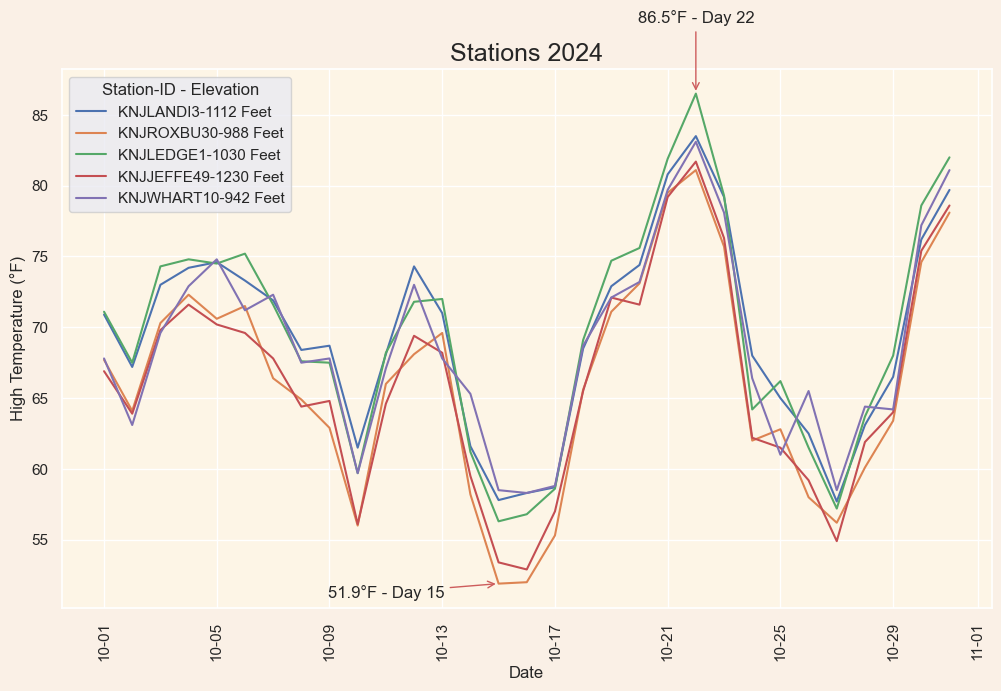

Year 2024 - Max Temperature: 86.5°F on 2024-10-22 - station KNJLEDGE1 at 1030 feet elevation
Year 2024 - Min Temperature: 51.9°F on 2024-10-15 - station KNJROXBU30 at 988 feet elevation


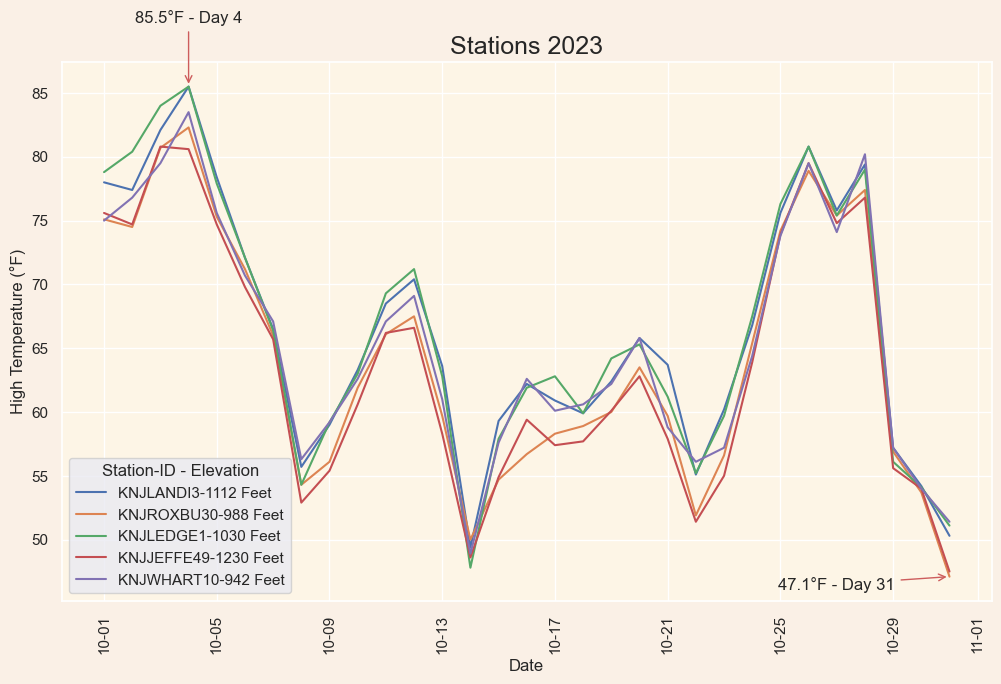

Year 2023 - Max Temperature: 85.5°F on 2023-10-04 - station KNJLANDI3 at 1112 feet elevation
Year 2023 - Min Temperature: 47.1°F on 2023-10-31 - station KNJROXBU30 at 988 feet elevation


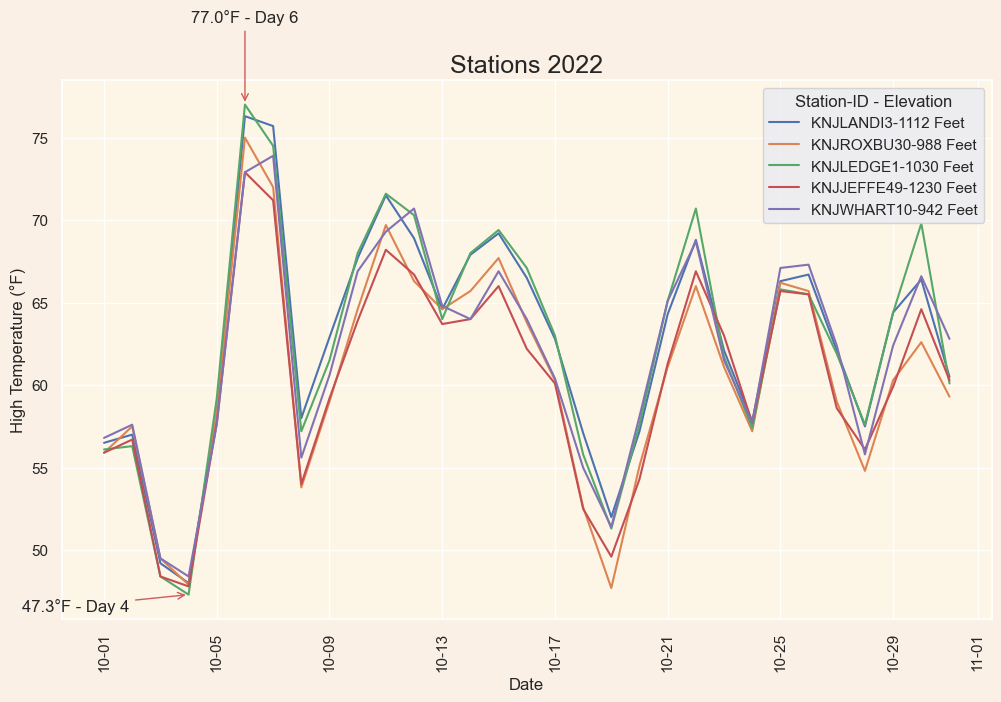

Year 2022 - Max Temperature: 77.0°F on 2022-10-06 - station KNJLEDGE1 at 1030 feet elevation
Year 2022 - Min Temperature: 47.3°F on 2022-10-04 - station KNJLEDGE1 at 1030 feet elevation


In [285]:
sns.set_style('dark')
sns.set_theme()
station_2024 = ['KNJLANDI3-2024', 'KNJROXBU30-2024', 'KNJLEDGE1-2024', 'KNJJEFFE49-2024', 'KNJWHART10-2024']
station_2023 = ['KNJLANDI3-2023', 'KNJROXBU30-2023', 'KNJLEDGE1-2023', 'KNJJEFFE49-2023', 'KNJWHART10-2023']
station_2022 = ['KNJLANDI3-2022', 'KNJROXBU30-2022', 'KNJLEDGE1-2022', 'KNJJEFFE49-2022', 'KNJWHART10-2022']
stations_by_year = [station_2024, station_2023, station_2022]   #list of stations by years to iterate through later
#print(weather_dfs)

for year in stations_by_year:   #outer loop of the plot. This iterates through years
    plt.figure(figsize=(12, 7));
    max_y_total = 0   # placeholders for figuring out max and min values for the graph
    max_x_total = None
    min_y_total = None
    min_x_total = None
    max_station = None
    min_station = None
    max_elevation = None
    min_elevation = None

    for key, value in weather_dfs.items():  #inner loop that sorts through the stations within the given year
        station_year = (key.split('-'))[0] + '-' + (key.split('-'))[1]  #string used for if statement, creates a string thats just station_id-year
        if station_year in year:    #if statement that filters the stations that only fit in the given year
            temp_high = pd.to_numeric(value['Temp_High'])   #convert high_temp to numeric so it can be properly plotted
            date = pd.to_datetime(value['Date'])    ##convert date to date type so it can be properly plotted
            station_alt = (key.split('-'))[0] + '-' + (key.split('-'))[2] + " Feet" #string made for labeling each line in the legend
                        
            sns.lineplot(x = date, y=temp_high, label= station_alt) #calls sns to make a lineplot 

            max_y = temp_high.max()             #these are used to figure out max and min temps and which day they happened.
            max_x = date[temp_high.idxmax()]    #used to annotate the graphs for clarity
            min_y = temp_high.min()
            min_x = date[temp_high.idxmin()]


            if max_y > max_y_total:  # if chain that properly updates the min and max value for the given year 
                max_y_total = max_y
                max_x_total = max_x
                max_station = (key.split('-'))[0]
                max_elevation = (key.split('-'))[2]

            if min_y_total is None:
                min_y_total = min_y
                min_x_total = min_x
                min_station = (key.split('-'))[0]
                min_elevation = (key.split('-'))[2]
            elif min_y < min_y_total:
                min_y_total = min_y
                min_x_total = min_x
                min_station = (key.split('-'))[0]
                min_elevation = (key.split('-'))[2]
    
    
    plt.annotate(f'{max_y_total:.1f}°F - Day {max_x_total.day}',  # Annotations used to display the max and min temperature value on the graph. 
             xy=(max_x_total, max_y_total),             # https://www.geeksforgeeks.org/matplotlib-pyplot-annotate-in-python/
             xytext=(max_x_total, max_y_total + 5), 
             ha='center', 
             arrowprops=dict(arrowstyle='->', color='#CD5C5C'))
    
    plt.annotate(f'{min_y_total:.1f}°F - Day {min_x_total.day}',  
             xy=(min_x_total, min_y_total),             
             xytext=(min_x_total - timedelta(days=4), min_y_total - 1), 
             ha='center', 
             arrowprops=dict(arrowstyle='->', color='#CD5C5C'))
    

    axis = plt.gca()                            #These are used to pretty up the chart. Mostly self explanatory 
    date_format = mdates.DateFormatter('%m-%d')
    axis.xaxis.set_major_formatter(date_format)
    station_id = (key.split('-'))[1]
    axis.set_facecolor('#fdf5e6')
    plt.gcf().patch.set_facecolor('#faf0e6')
    plt.title('Stations' + ' ' + (year[0].split('-')[1]), fontsize = 18)
    plt.xticks(rotation = 'vertical');
    plt.ylabel('High Temperature (°F)')
    plt.legend(title='Station-ID - Elevation')
    plt.show()

    #programmatically output the max and min temperatures
    print(f"Year {year[0].split('-')[1]} - Max Temperature: {max_y_total}°F on {max_x_total.strftime('%Y-%m-%d')} - station {max_station} at {max_elevation} feet elevation")
    print(f"Year {year[0].split('-')[1]} - Min Temperature: {min_y_total}°F on {min_x_total.strftime('%Y-%m-%d')} - station {min_station} at {min_elevation} feet elevation")


### Questions and conclusions 
What were the highest and lowest high temepratures in the month of october for the given years? Is there any correlation between elevation and daily high temperatures? 

In October from 2022 to 2024, the highest daily high temperatures were consistently recorded by station KNJLEDGE1 (1030 feet): 86.5°F in 2024, 85.5°F in 2023, and 77.0°F in 2022. The lowest daily highs were also consistent, primarily from KNJROXBU30 (988 feet), with 51.9°F in 2024 and 47.1°F in 2023. In 2022, KNJLEDGE1 itself recorded the lowest high at 47.3°F.

This pattern suggests a modest correlation between elevation and daily high temperatures, as KNJLEDGE1, positioned at a slightly higher elevation, recorded both the highest and lowest high temperatures across multiple years. However, the variation could also be influenced by other localized factors beyond elevation alone.

### Code Block: Plotting Low Temperatures with Programmatic Output

This code provides both visual and programmatic answers for low temperature data across different years.

1. **Visual Answers**:
   - Line plots are created for each year, showing low temperatures for each station.
   - Annotations mark the highest, lowest, and first frost temperatures (if applicable) on each plot.

2. **Programmatic Answers**:
   - After each plot, print statements output the max, min, and first frost temperatures (if available), including the date, station, and elevation.

This setup ensures both visual clarity and accessible text output for temperature extremes and frost dates by year.

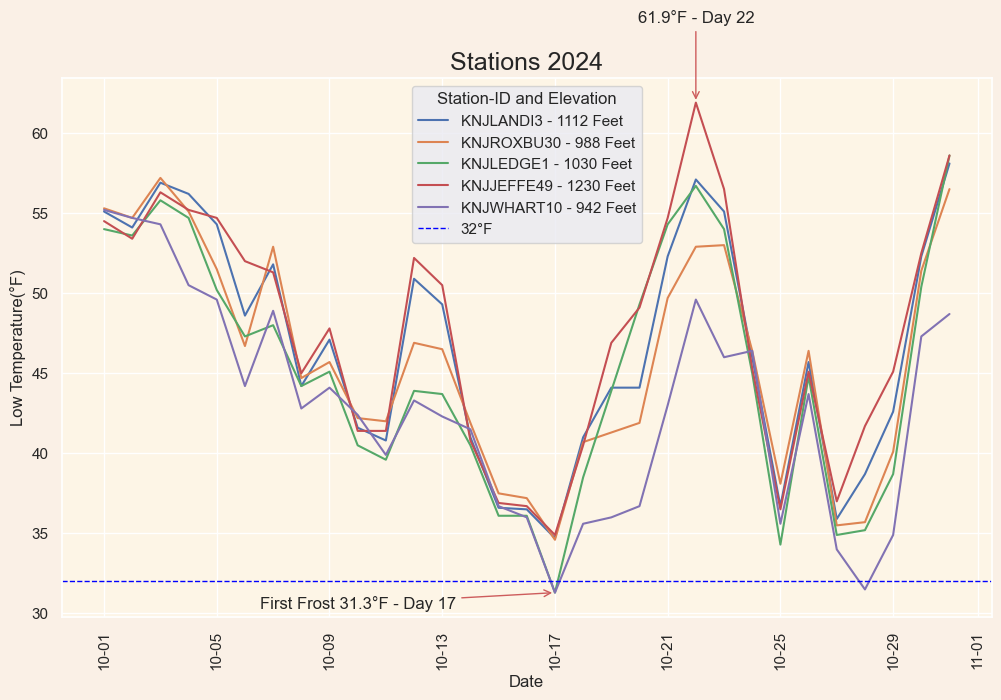

Year 2024 - Max Temperature: 61.9°F on 2024-10-22 - station KNJJEFFE49 at 1230 feet elevation
Year 2024 - Min Temperature: 31.3°F on 2024-10-17 - station KNJLEDGE1 at 1030 feet elevation
Year 2024 - First Frost: 31.3°F on 2024-10-17 - station KNJWHART10 at 942 feet elevation


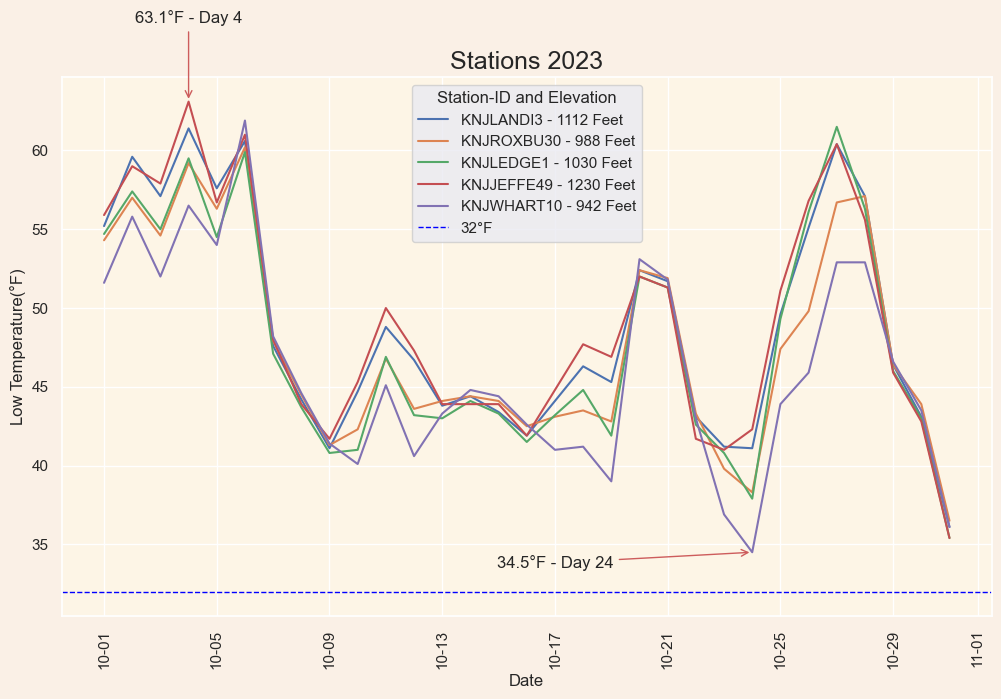

Year 2023 - Max Temperature: 63.1°F on 2023-10-04 - station KNJJEFFE49 at 1230 feet elevation
Year 2023 - Min Temperature: 34.5°F on 2023-10-24 - station KNJWHART10 at 942 feet elevation


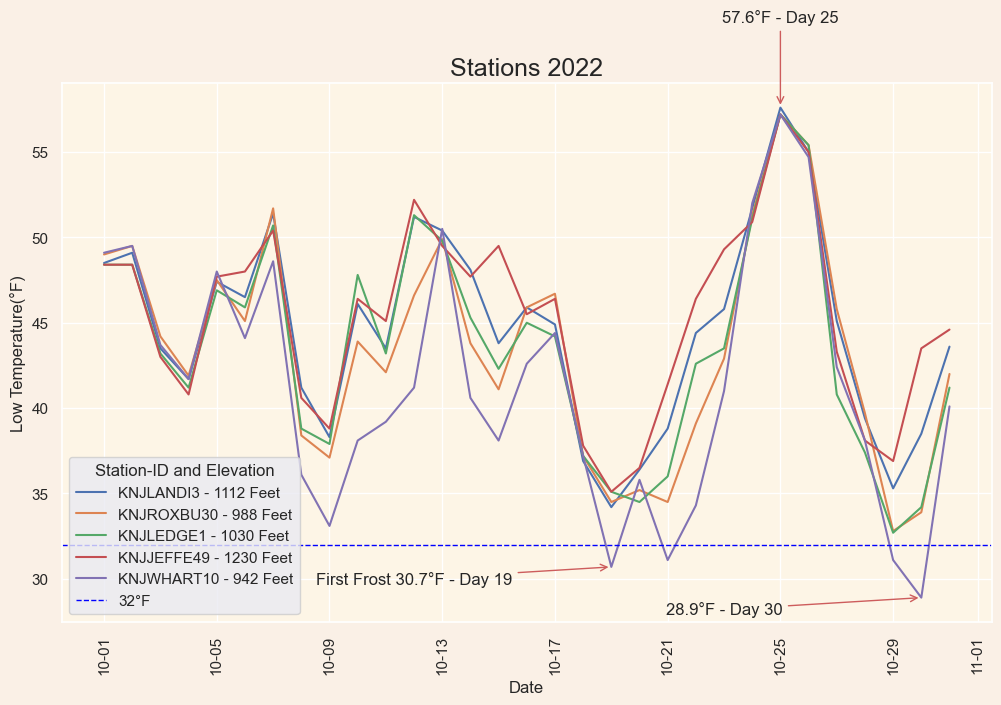

Year 2022 - Max Temperature: 57.6°F on 2022-10-25 - station KNJLANDI3 at 1112 feet elevation
Year 2022 - Min Temperature: 28.9°F on 2022-10-30 - station KNJWHART10 at 942 feet elevation
Year 2022 - First Frost: 30.7°F on 2022-10-19 - station KNJWHART10 at 942 feet elevation


In [284]:
sns.set_style('dark')
sns.set_theme()
station_2024 = ['KNJLANDI3-2024', 'KNJROXBU30-2024', 'KNJLEDGE1-2024', 'KNJJEFFE49-2024', 'KNJWHART10-2024']
station_2023 = ['KNJLANDI3-2023', 'KNJROXBU30-2023', 'KNJLEDGE1-2023', 'KNJJEFFE49-2023', 'KNJWHART10-2023']
station_2022 = ['KNJLANDI3-2022', 'KNJROXBU30-2022', 'KNJLEDGE1-2022', 'KNJJEFFE49-2022', 'KNJWHART10-2022']
stations_by_year = [station_2024, station_2023, station_2022]  # list of stations by years to iterate through later
#print(weather_dfs)

for year in stations_by_year:  # outer loop of the plot. This iterates through years
    plt.figure(figsize=(12, 7))
    max_y_total = 0   # placeholders for figuring out max and min values for the graph
    max_x_total = None
    min_y_total = None
    min_x_total = None
    first_frost_y = None
    first_frost_x = None
    max_station = None
    min_station = None
    freeze_station = None
    max_elevation = None
    min_elevation = None
    freeze_elevation = None

    for key, value in weather_dfs.items():  # inner loop that sorts through the stations within the given year
        station_year = (key.split('-'))[0] + '-' + (key.split('-'))[1]  # string used for if statement, creates a string that's just station_id-year
        if station_year in year:  # if statement that filters the stations that only fit in the given year
            temp = pd.to_numeric(value['Temp_Low'])  # convert low_temp to numeric so it can be properly plotted
            date = pd.to_datetime(value['Date'])  # convert date to date type so it can be properly plotted
            station_alt = (key.split('-'))[0] + ' - ' + (key.split('-'))[2] + " Feet"  # string made for labeling each line in the legend
                        
            sns.lineplot(x=date, y=temp, label=station_alt)  # calls sns to make a line plot

            max_y = temp.max()  # these are used to figure out max and min temps and which day they happened
            max_x = date[temp.idxmax()]  # used to annotate the graphs for clarity
            min_y = temp.min()
            min_x = date[temp.idxmin()]

            y_32 = temp <= 32  # identifies occurrences below freezing
            if y_32.any():
                first_below_freezing_index = y_32.idxmax()  # get first date with below-freezing temp
                first_frost_x = date[first_below_freezing_index]
                first_frost_y = temp[first_below_freezing_index]

            if max_y > max_y_total:  # if chain that properly updates the min and max value for the given year 
                max_y_total = max_y
                max_x_total = max_x
                max_station = (key.split('-'))[0]
                max_elevation = (key.split('-'))[2]

            if min_y <= 32:
                first_frost_y = first_frost_y
                first_frost_x = first_frost_x
                freeze_station = (key.split('-'))[0]
                freeze_elevation = (key.split('-'))[2]
            if min_y_total is None:
                min_y_total = min_y
                min_x_total = min_x
                min_station = (key.split('-'))[0]
                min_elevation = (key.split('-'))[2]
            elif min_y < min_y_total:
                min_y_total = min_y
                min_x_total = min_x
                min_station = (key.split('-'))[0]
                min_elevation = (key.split('-'))[2]
                

    
    
    plt.annotate(f'{max_y_total:.1f}°F - Day {max_x_total.day}',  #annotations used to display the max and min temperature value on the graph
                 xy=(max_x_total, max_y_total),  
                 xytext=(max_x_total, max_y_total + 5), 
                 ha='center', 
                 arrowprops=dict(arrowstyle='->', color='#CD5C5C'))
    
    if first_frost_y is None:
        plt.annotate(f'{min_y_total:.1f}°F - Day {min_x_total.day}',  
                     xy=(min_x_total, min_y_total),  
                     xytext=(min_x_total - timedelta(days=7), min_y_total - 1), 
                     ha='center', 
                     arrowprops=dict(arrowstyle='->', color='#CD5C5C'))
    elif min_y_total < first_frost_y:
        plt.annotate(f'{min_y_total:.1f}°F - Day {min_x_total.day}',  
                     xy=(min_x_total, min_y_total),  
                     xytext=(min_x_total - timedelta(days=7), min_y_total - 1), 
                     ha='center', 
                     arrowprops=dict(arrowstyle='->', color='#CD5C5C'))
        
        plt.annotate(f'First Frost {first_frost_y:.1f}°F - Day {first_frost_x.day}',  
                     xy=(first_frost_x, first_frost_y),  
                     xytext=(first_frost_x - timedelta(days=7), first_frost_y - 1), 
                     ha='center', 
                     arrowprops=dict(arrowstyle='->', color='#CD5C5C')) 
    else:
        plt.annotate(f'First Frost {first_frost_y:.1f}°F - Day {first_frost_x.day}',  
                     xy=(first_frost_x, first_frost_y),  
                     xytext=(first_frost_x - timedelta(days=7), first_frost_y - 1), 
                     ha='center', 
                     arrowprops=dict(arrowstyle='->', color='#CD5C5C'))

    
    plt.axhline(y=32, color='blue', linestyle='--', linewidth=1, label='32°F') #set a reference line at 32°F
    
                        
    axis = plt.gca()                                #customize plot appearance                    
    date_format = mdates.DateFormatter('%m-%d')
    axis.xaxis.set_major_formatter(date_format)
    axis.set_facecolor('#fdf5e6')
    plt.gcf().patch.set_facecolor('#faf0e6')
    plt.title('Stations' + ' ' + (year[0].split('-')[1]), fontsize=18)
    plt.xticks(rotation='vertical')
    plt.ylabel('Low Temperature(°F)')
    plt.legend(title='Station-ID and Elevation')
    plt.show()

    #programmatically output the max and min temperatures
    print(f"Year {year[0].split('-')[1]} - Max Temperature: {max_y_total}°F on {max_x_total.strftime('%Y-%m-%d')} - station {max_station} at {max_elevation} feet elevation")
    print(f"Year {year[0].split('-')[1]} - Min Temperature: {min_y_total}°F on {min_x_total.strftime('%Y-%m-%d')} - station {min_station} at {min_elevation} feet elevation")
    if first_frost_y is not None:
        print(f"Year {year[0].split('-')[1]} - First Frost: {first_frost_y}°F on {first_frost_x.strftime('%Y-%m-%d')} - station {freeze_station} at {freeze_elevation} feet elevation")


### Questions and conclusions

The statistical average for the first day of frost is October 10 for the area encompased by these stations. Did any stations have a frost in the month of october in any of the given years? Did first frost occur before the 10th of october in any given station for any of the years? 

What was the highest and the lowest daily low temperature between all the stations? Is there a correlation between station elevation and daily low temperature? 

From 2022 to 2024, station KNJJEFFE49 consistently recorded the highest daily low temperatures (61.9°F in 2024 and 63.1°F in 2023), with KNJLANDI3 reaching the highest low in 2022 at 57.6°F. KNJWHART10, at a lower elevation of 942 feet, logged the lowest lows each year (31.3°F in 2024, 34.5°F in 2023, and 28.9°F in 2022). 
This pattern suggests a potential link between higher elevation and warmer daily lows, with KNJJEFFE49 (at 1230 feet) often experiencing the warmer minimums compared to KNJWHART10( at 942 feet). KNJJEFFE49 is also notable the only station experienced frost in october of 2022. 

The line plots indicate that only two stations had first frost in october. Station KNJWHART10 and KNJLEDGE1 had teir first frost day on october 17th in 2024. No stations reported frost in october of 2023. KNJWHART10 was the only station to have frost in the month of october in 2022. 
No station in any of the years reported frost date on or before october 10. 

### Code Block: Plotting Cumulative Precipitation with Programmatic Output

This code provides both visual and programmatic answers for cumulative precipitation data across different years.

1. **Visual Answers**:
   - Line plots are created for each year, showing cumulative precipitation for each station.
   - Annotations mark the maximum cumulative precipitation on each plot.

2. **Programmatic Answers**:
   - After each plot, print statements output the highest cumulative precipitation, including the date, station, and elevation.

This setup ensures clear visual representation alongside accessible text output for maximum cumulative precipitation by year.

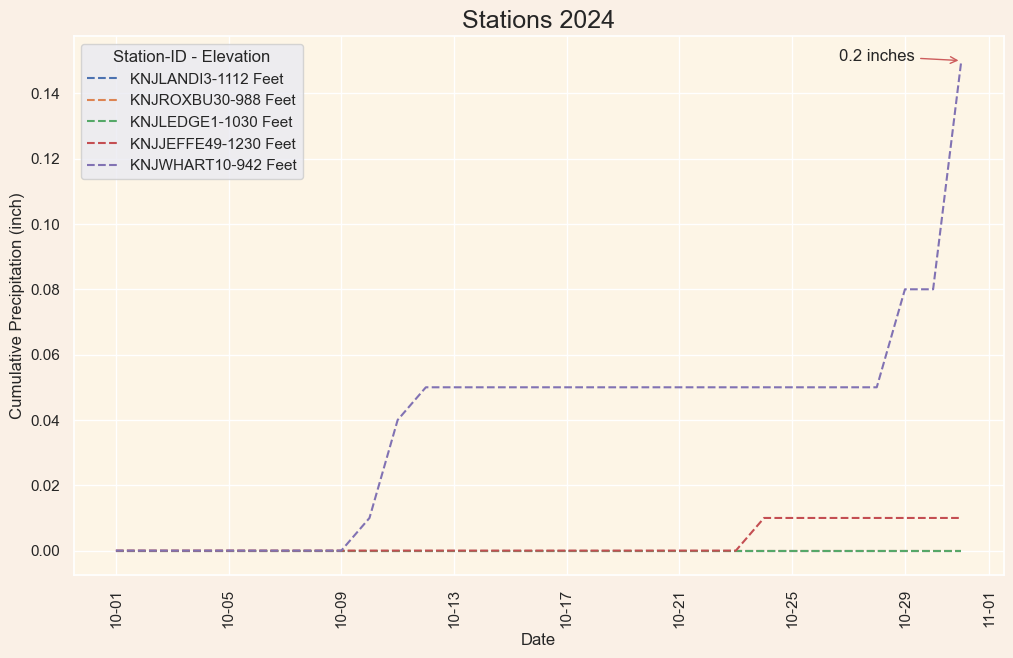

Year 2024 - Largest cumulative precipitation : 0.2 inches on 2024-10 - station KNJWHART10 at 942 feet elevation


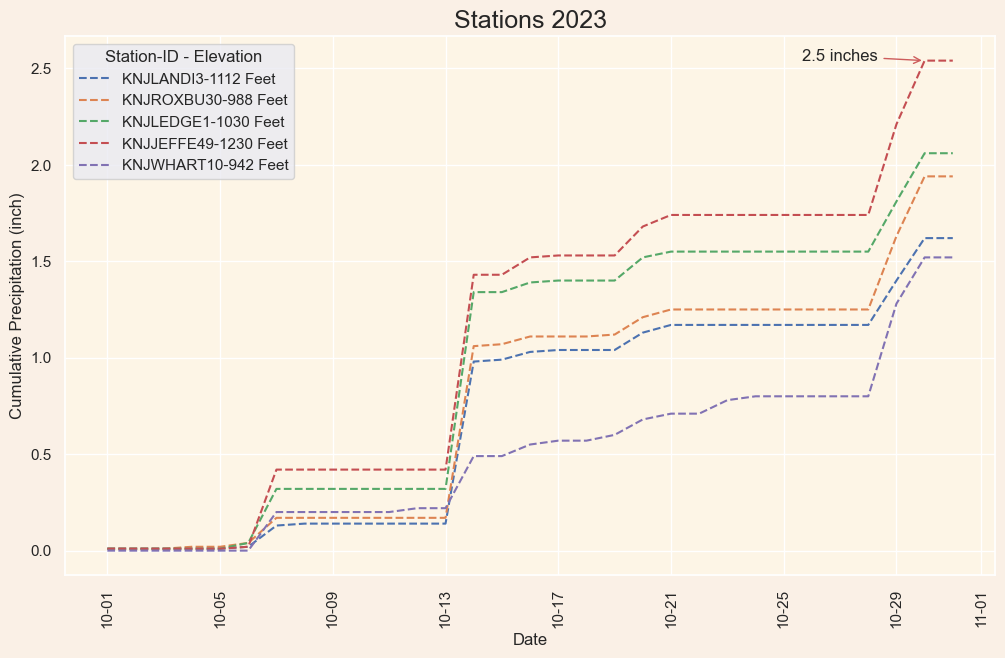

Year 2023 - Largest cumulative precipitation : 2.5 inches on 2023-10 - station KNJJEFFE49 at 1230 feet elevation


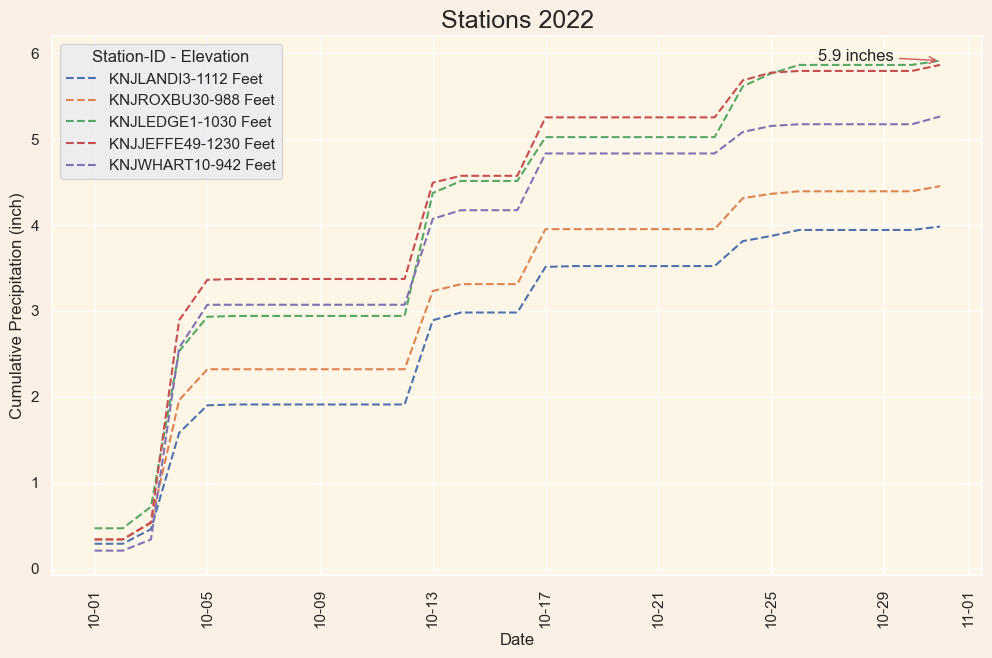

Year 2022 - Largest cumulative precipitation : 5.9 inches on 2022-10 - station KNJLEDGE1 at 1030 feet elevation


In [293]:
sns.set_style('dark')
sns.set_theme()
station_2024 = ['KNJLANDI3-2024', 'KNJROXBU30-2024', 'KNJLEDGE1-2024', 'KNJJEFFE49-2024', 'KNJWHART10-2024']
station_2023 = ['KNJLANDI3-2023', 'KNJROXBU30-2023', 'KNJLEDGE1-2023', 'KNJJEFFE49-2023', 'KNJWHART10-2023']
station_2022 = ['KNJLANDI3-2022', 'KNJROXBU30-2022', 'KNJLEDGE1-2022', 'KNJJEFFE49-2022', 'KNJWHART10-2022']
stations_by_year = [station_2024, station_2023, station_2022]
#print(weather_dfs)

for year in stations_by_year:
    plt.figure(figsize=(12, 7));
    max_y_total = 0
    max_x_total = None
    min_y_total = None
    min_x_total = None
    max_station = None
    max_elevation = None

    for key, value in weather_dfs.items():
        station_year = (key.split('-'))[0] + '-' + (key.split('-'))[1]
        if station_year in year:
            prec = pd.to_numeric(value['Daily_Precipitation'])
            date = pd.to_datetime(value['Date'])
            station_alt = (key.split('-'))[0] + '-' + (key.split('-'))[2] + " Feet"

            cumulative_prec = prec.cumsum()

            #sns.lineplot(x = date, y=prec, label= station_alt)
            sns.lineplot(x=date, y=cumulative_prec, label=f'{station_alt}', linestyle='--')

            max_y = cumulative_prec.max()
            max_x = date[cumulative_prec.idxmax()]
            min_y = cumulative_prec.min()
            min_x = date[cumulative_prec.idxmin()]

            if max_y > max_y_total:
                max_y_total = max_y
                max_x_total = max_x
                max_station = (key.split('-'))[0]
                max_elevation = (key.split('-'))[2]

    
    
    plt.annotate(f'{max_y_total:.1f} inches',  # Display the max temperature value with one decimal
             xy=(max_x_total, max_y_total),             # https://www.geeksforgeeks.org/matplotlib-pyplot-annotate-in-python/
             xytext=(max_x_total - timedelta(days=3), max_y_total), 
             ha='center', 
             arrowprops=dict(arrowstyle='->', color='#CD5C5C'))
    
    

    axis = plt.gca()
    date_format = mdates.DateFormatter('%m-%d')
    axis.xaxis.set_major_formatter(date_format)
    station_id = (key.split('-'))[1]
    axis.set_facecolor('#fdf5e6')
    plt.gcf().patch.set_facecolor('#faf0e6')
    plt.title('Stations' + ' ' + (year[0].split('-')[1]), fontsize = 18)
    plt.xticks(rotation = 'vertical');
    plt.ylabel('Cumulative Precipitation (inch)')
    plt.legend(title='Station-ID - Elevation')
    plt.show()

    print(f"Year {year[0].split('-')[1]} - Largest cumulative precipitation : {max_y_total:.1f} inches on {max_x_total.strftime('%Y-%m')} - station {max_station} at {max_elevation} feet elevation")

### Questions and Conclusions

Which year had the most cumulative precipitation in the month of october?
Which station was the highest in each given year? 

Is there visible correlation between elevation and cumulative precipitation? 

In October, 2022 saw the highest cumulative precipitation, with KNJLEDGE1 receiving the most at 5.9 inches. All stations reported over 4 inches that month, making it the rainiest of the years analyzed. In 2023, cumulative precipitation was significantly lower, with KNJJEFFE49 recording the highest total at 2.5 inches, and all stations seeing at least 1.5 inches. By contrast, in 2024, most stations recorded almost no precipitation, with KNJJEFFE49 reporting only 0.01 inches and KNJWHART10 slightly more at 0.2 inches.

There appears to be no visible correlation between elevation and cumulative precipitation across these years. Instead, year-to-year variability, especially with 2022 as a notably rainy year, seems to play a more substantial role in precipitation totals.